In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset

In [2]:
# считываем данные

ratings = pd.read_csv("ml-32m/ratings.csv")
movies = pd.read_csv("ml-32m/movies.csv")

### Датасет с рейтингами

In [3]:
ratings

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [4]:
users_id = ratings["userId"].unique()
movie_id = ratings["movieId"].unique()

In [5]:
print(f"Количество уникальных пользователей: {len(users_id):,}")
print(f"Количество уникальных фильмов: {len(movie_id):,}")

Количество уникальных пользователей: 200,948
Количество уникальных фильмов: 84,432


In [6]:
min_rating = ratings["rating"].min()
max_rating = ratings["rating"].max()
mean_rating = ratings["rating"].mean()
uniq_rating = ratings["rating"].unique()

print(f"Диапазон рейтинга: {min_rating} - {max_rating}")
print(f"Средний рейтинг: {mean_rating}")
print(f"Уникальные значения рейтингов: {np.sort(uniq_rating)}")

Диапазон рейтинга: 0.5 - 5.0
Средний рейтинг: 3.5403956487277393
Уникальные значения рейтингов: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


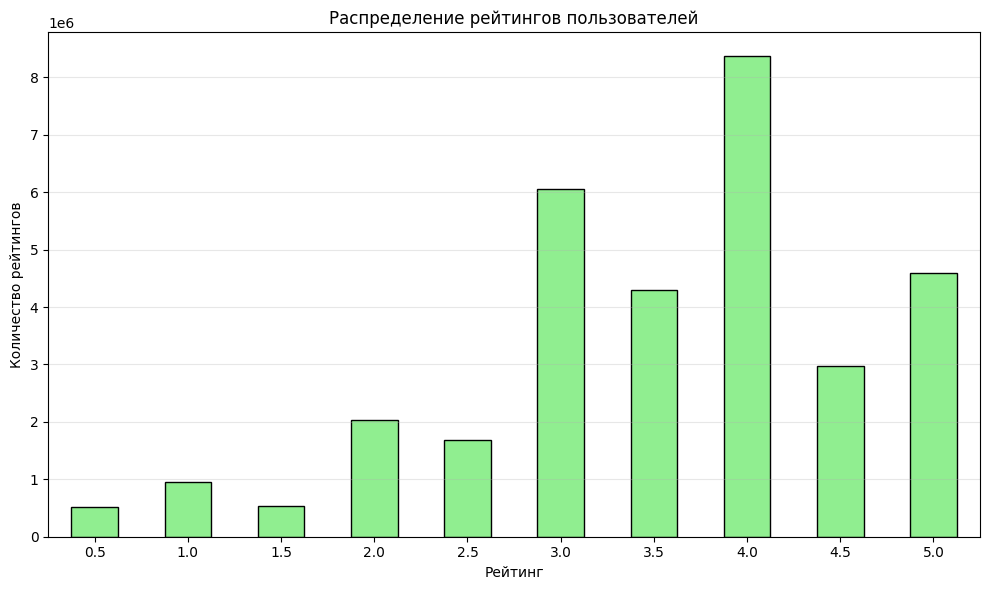

In [7]:
count_ratings = ratings["rating"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
count_ratings.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Распределение рейтингов пользователей')
plt.xlabel('Рейтинг')
plt.ylabel('Количество рейтингов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# преобразуем дату и посмотрим временной промежуток
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
min_date = ratings["date"].min()
max_date = ratings["date"].max()
print(f"Временной промежуток оценок в датасете: {min_date} - {max_date}")

Временной промежуток оценок в датасете: 1995-01-09 11:46:44 - 2023-10-13 02:29:07


In [9]:
# проверим на пропуски
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  int64         
 4   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.2 GB


In [10]:
# пропусков нет

In [11]:
# посмотрим на топ-10 популярных фильмов по количеству оценок
top_movies_indexes = ratings.groupby("movieId").count().sort_values("rating", ascending=False).head(10).index
top_movies = movies[movies["movieId"].isin(top_movies_indexes)]
top_movies

,movieId,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
314,318,"Shawshank Redemption, The (1994)",Crime|Drama
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War
475,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
522,527,Schindler's List (1993),Drama|War
585,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2867,2959,Fight Club (1999),Action|Crime|Drama|Thriller
4888,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy


In [12]:
# посмотрим на топ-10 популярных фильмов по среднему рейтингу
top_movies_rating_indexes = ratings.groupby("movieId").mean().sort_values("rating", ascending=False).head(10).index
top_movies_rating = movies[movies["movieId"].isin(top_movies_rating_indexes)]
top_movies_rating

,movieId,title,genres
24974,122649,The Bates Haunting (2013),Thriller
35576,147402,The King and Queen of Moonlight Bay (2003),Children|Drama
46660,171849,Without Family (1984),Children|Drama
59565,199103,Franco Escamilla: For the Anecdote (2018),Comedy
69952,225251,It Feels So Good (2019),Drama
79966,268054,Time of the Gods (1992),Documentary
79970,268090,"A Godwink Christmas: Second Chance, First Love...",Romance
79974,268114,Amazed By You (2018),Children
80068,268438,Paul McCartney: Back in the U.S. (2002),Documentary
80077,268476,Rebuilding a Dream Christmas (2021),Romance


In [13]:
ratings

,userId,movieId,rating,timestamp,date
0,1,17,4.0,944249077,1999-12-03 19:24:37
1,1,25,1.0,944250228,1999-12-03 19:43:48
2,1,29,2.0,943230976,1999-11-22 00:36:16
3,1,30,5.0,944249077,1999-12-03 19:24:37
4,1,32,5.0,943228858,1999-11-22 00:00:58
...,...,...,...,...,...
32000199,200948,79702,4.5,1294412589,2011-01-07 15:03:09
32000200,200948,79796,1.0,1287216292,2010-10-16 08:04:52
32000201,200948,80350,0.5,1294412671,2011-01-07 15:04:31
32000202,200948,80463,3.5,1350423800,2012-10-16 21:43:20


In [14]:
# удалим фильмы, у которых меньше 30 оценок
cnt_movies = ratings["movieId"].value_counts()
no_popular_movies = cnt_movies[cnt_movies < 30].index
ratings = ratings[~ratings["movieId"].isin(no_popular_movies)]

In [15]:
print("Количество фильмов:", len(ratings["movieId"].unique()))

Количество фильмов: 19670


In [16]:
# разделим на train и test по временной метке
threshold = 0.8
time_threshold = ratings['timestamp'].quantile(threshold)

train_data_1 = ratings[ratings['timestamp'] <= time_threshold]
test_data_1 = ratings[ratings['timestamp'] > time_threshold]

In [17]:
# удалим из train пользователей, которых нет в train
users_in_test = test_data_1["userId"].unique()
train_data_clean = train_data_1[train_data_1["userId"].isin(users_in_test)]

In [18]:
print(f"Было до очистки: {train_data_1.shape[0]:,}")
print(f"Стало после очистки: {train_data_clean.shape[0]:,}")
print(f"Разница: {train_data_1.shape[0] - train_data_clean.shape[0]: ,}")

Было до очистки: 25,310,168
Стало после очистки: 3,488,951
Разница:  21,821,217


In [19]:
# получилось очень-не очень, поэтому разделим немного по-другому:
# будем делить по временной отметки, которая будет рассчитываться для каждого пользователя

In [20]:
# посмотрим сколько вообще оценок у пользователей
ratings["userId"].value_counts()

userId
175325    14050
17035      7705
55653      7650
49305      7265
123465     6996
          ...  
68486         8
110480        7
81281         7
133045        6
123780        6
Name: count, Length: 200948, dtype: int64

In [21]:
# напишем функцию для деления на train и test
# будем делить по следующим правилам:
#     - для каждого пользователя считаем квантиль времени и все что до квантиля - train, остальное в test
#     - в test для каждого пользователя хотя бы 100 оценок
def my_split(df, test_size=0.2, min_test_ratings=100):

    df_sorted = df.sort_values(['userId', 'timestamp']).reset_index(drop=True)
    
    user_groups = df_sorted.groupby('userId')
    user_indices = {user_id: group.index for user_id, group in user_groups}
    
    train_indices = []
    test_indices = []
    user_stats = []
    
    for user_id, indices in tqdm(user_indices.items(), desc="Processing users"):
        user_ratings = df_sorted.loc[indices]
        n_ratings = len(user_ratings)
        
        if n_ratings < min_test_ratings + 1:
            continue
        
        timestamps = user_ratings['timestamp'].values
        time_quantile = np.quantile(timestamps, 1 - test_size)
        
        test_mask = timestamps > time_quantile
        n_test = test_mask.sum()
        
        if n_test >= min_test_ratings:
            train_indices.extend(indices[~test_mask])
            test_indices.extend(indices[test_mask])
            method = 'quantile'
            n_train = n_ratings - n_test
        else:
            continue
        
        user_stats.append({
            'userId': user_id,
            'total_ratings': n_ratings,
            'train_ratings': n_train,
            'test_ratings': n_test,
            'method': method
        })
    
    train_data = df_sorted.loc[train_indices].reset_index(drop=True)
    test_data = df_sorted.loc[test_indices].reset_index(drop=True)
    
    test_counts = test_data.groupby('userId').size()
    print(f"Пользователей в test: {len(test_counts):,}")
    
    return train_data, test_data, pd.DataFrame(user_stats)
        

In [22]:
df_train, df_test, u_s = my_split(ratings)

Processing users: 100%|███████████████| 200948/200948 [00:30<00:00, 6690.66it/s]


Пользователей в test: 12,405


In [23]:
dim_train = df_train.shape[0]
dim_test = df_test.shape[0]
print(f"Строк в train: {dim_train:,}")
print(f"Строк в test: {dim_test:,}")

Строк в train: 9,228,570
Строк в test: 2,289,657


In [24]:
# напишем метрики
def precision_at_k(recommendations, test_data, k=50):
    """
    Precision@K
    """
    precisions = []
    
    for user_id, (pred_items, pred_scores) in recommendations.items():

        user_test = test_data[test_data['userId'] == user_id]
        relevant_items = set(user_test[user_test['rating'] >= 3.0]['movieId'])
        
        top_k_items = set(pred_items[:k])
        
        if len(top_k_items) > 0:
            precision = len(top_k_items & relevant_items) / len(top_k_items)
            precisions.append(precision)
    
    return np.mean(precisions) if precisions else 0

def map_at_k(recommendations, test_data, k=50):
    """
    MAP@K
    """
    average_precisions = []
    
    for user_id, (pred_items, pred_scores) in recommendations.items():

        user_test = test_data[test_data['userId'] == user_id]
        relevant_items = set(user_test[user_test['rating'] >= 3.0]['movieId'])
        
        top_k_items = pred_items[:k]
        
        precision_at_n = []
        hits = 0
        
        for n, item in enumerate(top_k_items, 1):
            if item in relevant_items:
                hits += 1
                precision_at_n.append(hits / n)
        
        if len(relevant_items) > 0:
            ap = sum(precision_at_n) / min(len(relevant_items), k)
            average_precisions.append(ap)
        else:
            average_precisions.append(0.0)
    
    return np.mean(average_precisions) if average_precisions else 0.0
def ndcg_at_k(recommendations, test_data, k=50):
    """
     NDCG@K
    """
    ndcg_scores = []
    
    for user_id, (pred_items, pred_scores) in recommendations.items():
        user_test = test_data[test_data['userId'] == user_id]
        true_ratings_dict = user_test.set_index('movieId')['rating'].to_dict()
        
        top_k_items = pred_items[:k]
        
        dcg = 0.0
        for i, movie_id in enumerate(top_k_items):
            true_rating = true_ratings_dict.get(movie_id, 0)
            discount = np.log2(i + 2)
            dcg += (2 ** true_rating - 1) / discount
        
        user_true_ratings = [true_ratings_dict.get(mid, 0) for mid in top_k_items]
        ideal_ratings = sorted(user_true_ratings, reverse=True)
        
        idcg = 0.0
        for i, rating in enumerate(ideal_ratings):
            discount = np.log2(i + 2)
            idcg += (2 ** rating - 1) / discount

        if idcg > 0:
            ndcg_scores.append(dcg / idcg)
    
    return np.mean(ndcg_scores) if ndcg_scores else 0.0

In [25]:
# baseline model

class BaselinePopularRecommender:
    def __init__(self):
        self.popular_movies = None

    def recommended(self, df, top_k=50):
        if self.popular_movies is not None:
            return self.popular_movies

        self.popular_movies = (
            df.groupby("movieId").count().sort_values(
                "rating", ascending=False).head(top_k).index)
        
        return self.popular_movies, [5.0 for _ in range(len(self.popular_movies))]

In [26]:
popular_model = BaselinePopularRecommender()
popular_movies = popular_model.recommended(df_train)
popular_movies[0]

Index([2571,  356,  296,  593,  318,  480,  260, 1270, 1196, 1580, 4993, 1198,
       2959, 2762,    1, 1210, 3578, 2858,  589, 1265,   47, 4306, 2028, 1682,
       5952, 1240,  780,   50,  110, 1036,  608, 2716,  858, 7153, 1704, 4226,
       1721, 3793, 1291, 1214, 5349, 1527, 1097, 2628, 6539,  527,   32,  541,
       1089, 4963],
      dtype='int64', name='movieId')

In [27]:
prediction_popular_movies = {user_id: popular_movies for user_id in df_test["userId"].unique()}

In [28]:
precision_baseline = precision_at_k(prediction_popular_movies, df_test)
map_baseline = map_at_k(prediction_popular_movies, df_test)

In [29]:
print(f"Precision@50 для baseline модели: {precision_baseline}")
print(f"MAP@50 для baseline модели: {map_baseline}")

Precision@50 для baseline модели: 0.054695687222893995
MAP@50 для baseline модели: 0.010582735910267864


#### User-based подход

In [30]:
class UserBasedRecommender:
    def __init__(self):
        self.sparse_matrix = None
        self.user_to_idx = None
        self.movie_to_idx = None
        self.idx_to_user = None
        self.idx_to_movie = None
        self.user_similarity = None

    def create_sparse_matrix(self, df: pd.DataFrame):
        user_ids = df["userId"].unique()
        movie_ids = df["movieId"].unique()

        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
        self.movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

        self.idx_to_user = {idx: user_id for user_id, idx in self.user_to_idx.items()}
        self.idx_to_movie = {idx: movie_id for movie_id, idx in self.movie_to_idx.items()}

        rows = df["userId"].map(self.user_to_idx)
        cols = df["movieId"].map(self.movie_to_idx)
        ratings = df["rating"].values

        self.sparse_matrix = csr_matrix(
            (ratings, (rows, cols)),
            shape=(len(user_ids), len(movie_ids))
        )
        return self.sparse_matrix

    def calc_users_similarities(self):
        assert self.sparse_matrix is not None, ("Сначала нужно создатль матрицу")
        self.user_similarity = cosine_similarity(self.sparse_matrix)
        return self.user_similarity

    def recommend_for_user_idx(self, user_id, top_k=30, n_similar=20):
        """
        Рекомендации по индексу пользователя
        """
        assert self.sparse_matrix is not None, "Сначала нужно создать матрицу"

        user_idx = self.user_to_idx[user_id]
        user_sims = self.user_similarity[user_idx]
        similar_users_idx = np.argsort(user_sims)[::-1][1:n_similar + 1]
        similar_users_sims = user_sims[similar_users_idx]

        similar_users_ratings = self.sparse_matrix[similar_users_idx]
        weighted_ratings = similar_users_sims @ similar_users_ratings
        sum_similarities = np.abs(similar_users_sims).sum()

        predicted_scores = weighted_ratings / sum_similarities if sum_similarities > 0 else np.zeros(
            self.sparse_matrix.shape[1])

        user_ratings = self.sparse_matrix[user_idx]
        watched_movies_idx = user_ratings.nonzero()[1]
        predicted_scores[watched_movies_idx] = -np.inf
        top_items_idx = np.argsort(predicted_scores)[::-1][:top_k]
        top_scores = predicted_scores[top_items_idx]
        
        top_movie_ids = [self.idx_to_movie[idx] for idx in top_items_idx]

        return top_movie_ids, top_scores

    def recommend(self, user_ids, top_k=30, n_similar=50, verbose=True):
        assert self.user_similarity is not None, "Сначала нужно создать матрицу"
        recommendations = {}
        for user_id in user_ids:
            top_movie_ids, top_scores = self.recommend_for_user_idx(
                user_id, top_k, n_similar
            )
            recommendations[user_id] = (top_movie_ids, top_scores)
        return recommendations


In [31]:
# обучим наш класс
rec = UserBasedRecommender()
rec.create_sparse_matrix(df_train)
rec.calc_users_similarities()

array([[1.        , 0.32433658, 0.24178668, ..., 0.41733328, 0.36534259,
        0.30300494],
       [0.32433658, 1.        , 0.2545661 , ..., 0.31400357, 0.3606395 ,
        0.36033966],
       [0.24178668, 0.2545661 , 1.        , ..., 0.25995503, 0.28906809,
        0.22669355],
       ...,
       [0.41733328, 0.31400357, 0.25995503, ..., 1.        , 0.35282658,
        0.23464577],
       [0.36534259, 0.3606395 , 0.28906809, ..., 0.35282658, 1.        ,
        0.31533319],
       [0.30300494, 0.36033966, 0.22669355, ..., 0.23464577, 0.31533319,
        1.        ]])

In [32]:
df_test

,userId,movieId,rating,timestamp,date
0,10,76251,4.0,1272714819,2010-05-01 11:53:39
1,10,77561,3.0,1273642076,2010-05-12 05:27:56
2,10,74789,2.5,1274608709,2010-05-23 09:58:29
3,10,77866,2.0,1275644192,2010-06-04 09:36:32
4,10,79139,2.5,1280754084,2010-08-02 13:01:24
...,...,...,...,...,...
2289652,200943,135567,1.0,1494478245,2017-05-11 04:50:45
2289653,200943,27482,1.5,1494478348,2017-05-11 04:52:28
2289654,200943,55274,4.0,1494478357,2017-05-11 04:52:37
2289655,200943,66198,4.0,1494478417,2017-05-11 04:53:37


In [33]:
# сделаем предсказание для однго пользователя из теста
rec.recommend_for_user_idx(200943)

([110,
  2028,
  296,
  1617,
  4226,
  953,
  1222,
  1625,
  6539,
  5989,
  2115,
  3147,
  1258,
  6377,
  4995,
  8874,
  2791,
  1923,
  4011,
  597,
  48780,
  1721,
  587,
  1393,
  1275,
  527,
  1089,
  1259,
  1968,
  474],
 array([4.19890367, 4.17704569, 4.12358779, 3.94889648, 3.84442216,
        3.72579962, 3.65294934, 3.63107975, 3.60513853, 3.59889119,
        3.57590444, 3.541726  , 3.52202592, 3.48318907, 3.46065952,
        3.45990739, 3.45653798, 3.42869373, 3.42271648, 3.40086861,
        3.38094408, 3.37946807, 3.37331984, 3.35480608, 3.3404864 ,
        3.32188261, 3.28202708, 3.27490919, 3.23074595, 3.22563386]))

In [34]:
# сделаем предсказание для всего теста
user_based_recommendations = rec.recommend(df_test['userId'].unique())

In [36]:
# посчитаем метрики
precision_user_based_model = precision_at_k(user_based_recommendations, df_test)
map_user_based_model = map_at_k(user_based_recommendations, df_test)
ndcg_user_based_model = ndcg_at_k(user_based_recommendations, df_test)

In [37]:
print(f"Precision@50 для User-based подхода: {precision_user_based_model}")
print(f"MAP@50 для User-based подхода: {map_user_based_model}")
print(f"NDCG@50 для User-based подхода: {ndcg_user_based_model}")

Precision@50 для User-based подхода: 0.24775493752519145
MAP@50 для User-based подхода: 0.08194926734576582
NDCG@50 для User-based подхода: 0.6050833309979654


#### Item-based подход

In [38]:
class ItemBasedRecommender:
    def __init__(self, n_similar_items=50):
        self.sparse_matrix = None
        self.user_to_idx = None
        self.movie_to_idx = None
        self.idx_to_user = None
        self.idx_to_movie = None
        self.item_similarity = None
        self.n_similar_items = n_similar_items

    def create_sparse_matrix(self, df, n_items=1000):

        popular_movies = df['movieId'].value_counts().head(n_items).index
        df_filtered = df[df['movieId'].isin(popular_movies)]
        
        user_ids = df_filtered["userId"].unique()
        movie_ids = df_filtered["movieId"].unique()

        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
        self.movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
        self.idx_to_user = {idx: user_id for user_id, idx in self.user_to_idx.items()}
        self.idx_to_movie = {idx: movie_id for movie_id, idx in self.movie_to_idx.items()}

        rows = df_filtered["userId"].map(self.user_to_idx)
        cols = df_filtered["movieId"].map(self.movie_to_idx)
        ratings = df_filtered["rating"].values

        self.sparse_matrix = csr_matrix(
            (ratings, (rows, cols)),
            shape=(len(user_ids), len(movie_ids))
        )
        return self.sparse_matrix

    def calc_items_similarities(self):
        assert self.sparse_matrix is not None, "Сначала нужно создать матрицу"
    
        n_items = self.sparse_matrix.shape[1]
        self.item_similarity_topk = {}
        
        for item_idx in tqdm(range(n_items)):
            item_vector = self.sparse_matrix[:, item_idx].T
            similarities = cosine_similarity(item_vector, self.sparse_matrix.T)[0]
            
            top_indices = np.argsort(similarities)[::-1][1:self.n_similar_items+1]
            top_similarities = similarities[top_indices]
            
            self.item_similarity_topk[item_idx] = (top_indices, top_similarities)
        
        return self.item_similarity_topk

    def recommend_for_user(self, user_id, top_k=50):
        if user_id not in self.user_to_idx:
            return np.array([]), np.array([])

        user_idx = self.user_to_idx[user_id]
        user_ratings = self.sparse_matrix[user_idx]
        rated_items_idx = user_ratings.nonzero()[1]
        
        if len(rated_items_idx) == 0:
            return np.array([]), np.array([])

        predictions = {}

        for rated_item_idx in rated_items_idx:
            if rated_item_idx not in self.item_similarity_topk:
                continue
                
            similar_items_idx, similarities = self.item_similarity_topk[rated_item_idx]
            user_rating = user_ratings[0, rated_item_idx]
            
            for sim_item_idx, similarity in zip(similar_items_idx, similarities):
                if sim_item_idx in rated_items_idx: 
                    continue
                    
                if sim_item_idx not in predictions:
                    predictions[sim_item_idx] = (0.0, 0.0)
                
                weighted_sum, sum_weights = predictions[sim_item_idx]
                weighted_sum += similarity * user_rating
                sum_weights += abs(similarity)
                predictions[sim_item_idx] = (weighted_sum, sum_weights)
        
        final_predictions = []
        for item_idx, (weighted_sum, sum_weights) in predictions.items():
            if sum_weights > 0:
                predicted_score = weighted_sum / sum_weights
                movie_id = self.idx_to_movie[item_idx]
                final_predictions.append((movie_id, predicted_score))
        
        final_predictions.sort(key=lambda x: x[1], reverse=True)
        items = np.array([x[0] for x in final_predictions[:top_k]])
        scores = np.array([x[1] for x in final_predictions[:top_k]])
        
        return items, scores

    def recommend(self, user_ids, top_k=50):
        recommendations = {}
        user_ids_sample = list(user_ids)
        
        for i, user_id in enumerate(user_ids_sample):
                
            items, scores = self.recommend_for_user(user_id, top_k)
            recommendations[user_id] = (items, scores)
            
        return recommendations

In [40]:
item_model = ItemBasedRecommender()
item_model.create_sparse_matrix(df_train)
item_model.calc_items_similarities()
item_recommendations = item_model.recommend(df_test['userId'].unique())

precision_item = precision_at_k(item_recommendations, df_test)
map_item = map_at_k(item_recommendations, df_test)
ndcg_user_item = ndcg_at_k(item_recommendations, df_test)

100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.72it/s]


In [41]:
print(f"Precision@50 для Item-based подхода: {precision_item}")
print(f"MAP@50 для Item-based подхода: {map_item}")
print(f"NDCG@50 для Item-based подхода: {ndcg_user_item}")

Precision@50 для Item-based подхода: 0.1320228179548794
MAP@50 для Item-based подхода: 0.03647717173299491
NDCG@50 для Item-based подхода: 0.4164661741459025


#### SVD

In [42]:
class SVDRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, 
                 min_ratings=10, max_items=100):
        self.algo = SVD(n_factors=n_factors, n_epochs=n_epochs, 
                       lr_all=lr_all, reg_all=reg_all, random_state=42)
        self.trainset = None
        self.min_ratings = min_ratings
        self.max_items = max_items
        self.popular_movies = None
        
    def filter_data(self, df):
        movie_counts = df['movieId'].value_counts()
        
        self.popular_movies = movie_counts.head(self.max_items).index
        df_filtered = df[df['movieId'].isin(self.popular_movies)]
                
        return df_filtered
        
    def fit(self, df_train):
        df_filtered = self.filter_data(df_train)
        
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(df_filtered[['userId', 'movieId', 'rating']], reader)
        
        self.trainset = data.build_full_trainset()
        self.algo.fit(self.trainset)
        
        return self
    
    def recommend_for_user(self, user_id, top_k=50):
        user_inner_id = None
        try:
            user_inner_id = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return np.array([]), np.array([])
        user_ratings = self.trainset.ur[user_inner_id]
        rated_items = {rating[0] for rating in user_ratings}
        
        predictions = []
        for item_inner_id in range(self.trainset.n_items):
            if item_inner_id not in rated_items:
                user_bias = self.algo.bu[user_inner_id]
                item_bias = self.algo.bi[item_inner_id]
                user_factors = self.algo.pu[user_inner_id]
                item_factors = self.algo.qi[item_inner_id]
                
                est = self.trainset.global_mean + user_bias + item_bias + np.dot(user_factors, item_factors)
                item_raw_id = self.trainset.to_raw_iid(item_inner_id)
                predictions.append((item_raw_id, est))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        items = np.array([x[0] for x in predictions[:top_k]])
        scores = np.array([x[1] for x in predictions[:top_k]])
        
        return items, scores
    
    def recommend(self, user_ids, top_k=50):
        recommendations = {}
        
        for user_id in tqdm(user_ids):
            items, scores = self.recommend_for_user(user_id, top_k)
            recommendations[user_id] = (items, scores)
            
        return recommendations

In [43]:
svd_recommender = SVDRecommender(
    n_factors=300,
    n_epochs=100,
    lr_all=0.01,
    reg_all=0.02,
    )
    
svd_recommender.fit(df_train)
recommendations_svd = svd_recommender.recommend(df_test['userId'].unique(), top_k=50)

precision_svd = precision_at_k(recommendations_svd, df_test, k=50)
map_svd = map_at_k(recommendations_svd, df_test, k=50)
ndcg_svd = ndcg_at_k(recommendations_svd, df_test, k=50)

100%|██████████████████████████████████| 12405/12405 [00:00<00:00, 27335.70it/s]


In [44]:
print(f"Precision@50 SVD: {precision_svd:.4f}")
print(f"MAP@50 SVD: {map_svd:.4f}")
print(f"NDCG@50 SVD: {ndcg_svd:.4f}")

Precision@50 SVD: 0.2037
MAP@50 SVD: 0.0562
NDCG@50 SVD: 0.5969


#### Модель с использованием кластеризации

In [45]:
from sklearn.cluster import KMeans

In [46]:
class UserClusterRecommender:
    def __init__(self, n_clusters=20, min_ratings=10, max_items=2000):
        self.n_clusters = n_clusters
        self.min_ratings = min_ratings
        self.max_items = max_items
        
        self.kmeans = None
        self.cluster_ratings = None
        self.sparse_matrix = None
        self.user_to_idx = None
        self.movie_to_idx = None
        self.idx_to_user = None
        self.idx_to_movie = None
        self.user_clusters = None
        
    def filter_data(self, df):
        movie_counts = df['movieId'].value_counts()
        popular_movies = movie_counts.head(self.max_items).index
        df_filtered = df[df['movieId'].isin(popular_movies)]
        return df_filtered
        
    def create_sparse_matrix(self, df):
        
        user_ids = df["userId"].unique()
        movie_ids = df["movieId"].unique()

        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
        self.movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
        self.idx_to_user = {idx: user_id for user_id, idx in self.user_to_idx.items()}
        self.idx_to_movie = {idx: movie_id for movie_id, idx in self.movie_to_idx.items()}

        rows = df["userId"].map(self.user_to_idx)
        cols = df["movieId"].map(self.movie_to_idx)
        ratings = df["rating"].values

        self.sparse_matrix = csr_matrix(
            (ratings, (rows, cols)),
            shape=(len(user_ids), len(movie_ids))
        )
        return self.sparse_matrix
    
    def fit(self, df_train):

        df_filtered = self.filter_data(df_train)
        self.create_sparse_matrix(df_filtered)
        
        n_users, n_items = self.sparse_matrix.shape

        user_matrix = self.sparse_matrix.toarray()
        
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.user_clusters = self.kmeans.fit_predict(user_matrix)
        

        self.cluster_ratings = np.zeros((self.n_clusters, n_items))
        cluster_counts = np.zeros((self.n_clusters, n_items))
        
        for user_idx in tqdm(range(n_users)):
            cluster_id = self.user_clusters[user_idx]
            user_ratings = self.sparse_matrix[user_idx]
            
            for movie_idx in range(n_items):
                rating = user_ratings[0, movie_idx]
                if rating > 0:
                    self.cluster_ratings[cluster_id, movie_idx] += rating
                    cluster_counts[cluster_id, movie_idx] += 1
        
        global_mean = self.sparse_matrix.data.mean() if len(self.sparse_matrix.data) > 0 else 3.0
        for cluster_id in range(self.n_clusters):
            for movie_idx in range(n_items):
                if cluster_counts[cluster_id, movie_idx] > 0:
                    self.cluster_ratings[cluster_id, movie_idx] /= cluster_counts[cluster_id, movie_idx]
                else:
                    self.cluster_ratings[cluster_id, movie_idx] = global_mean
        
        cluster_sizes = np.bincount(self.user_clusters)

        return self
    
    def predict_rating(self, user_id, movie_id):
        if user_id not in self.user_to_idx or movie_id not in self.movie_to_idx:
            return self.sparse_matrix.data.mean() if len(self.sparse_matrix.data) > 0 else 3.0
        
        user_idx = self.user_to_idx[user_id]
        movie_idx = self.movie_to_idx[movie_id]
        
        cluster_id = self.user_clusters[user_idx]
        return self.cluster_ratings[cluster_id, movie_idx]
    
    def recommend_for_user(self, user_id, top_k=30):
        if user_id not in self.user_to_idx:
            return np.array([]), np.array([])
        
        user_idx = self.user_to_idx[user_id]
        user_ratings = self.sparse_matrix[user_idx]
        rated_items = set(user_ratings.nonzero()[1])
        
        predictions = []
        for movie_idx in range(len(self.movie_to_idx)):
            if movie_idx not in rated_items:
                movie_id = self.idx_to_movie[movie_idx]
                score = self.predict_rating(user_id, movie_id)
                predictions.append((movie_id, score))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        items = np.array([x[0] for x in predictions[:top_k]])
        scores = np.array([x[1] for x in predictions[:top_k]])
        
        return items, scores
    
    def recommend(self, user_ids, top_k=30):
        recommendations = {}
        
        for user_id in tqdm(user_ids):
            items, scores = self.recommend_for_user(user_id, top_k)
            if len(items) > 0:
                recommendations[user_id] = (items, scores)
        
        return recommendations

In [47]:
cluster_recommender = UserClusterRecommender(
    n_clusters=20,
    min_ratings=10,
    max_items=10
)

cluster_recommender.fit(df_train)

test_users = df_test['userId'].unique()
recommendations_cluster = cluster_recommender.recommend(test_users, top_k=50)

precision_cluster = precision_at_k(recommendations_cluster, df_test, k=50)
map_cluster = map_at_k(recommendations_cluster, df_test, k=50)
ndcg_cluster = ndcg_at_k(recommendations_cluster, df_test, k=50)

100%|██████████████████████████████████| 12405/12405 [00:00<00:00, 18576.17it/s]


In [48]:
print(f"Precision@50: {precision_cluster:.4f}")
print(f"MAP@50: {map_cluster:.4f}")
print(f"NDCG@50: {ndcg_cluster:.4f}")

Precision@50: 0.3343
MAP@50: 0.0132
NDCG@50: 0.8622


#### Итоговое сравнение метрик

In [51]:
# Popular Baseline
print("Baseline")
print(f"Precision@50: {precision_baseline}")
print(f"MAP@50: {map_baseline}")

print("User-based")
print(f"Precision@50: {precision_user_based_model}")
print(f"MAP@50: {map_user_based_model}")
print(f"NDCG@50: {ndcg_user_based_model}")

print("Item-based")
print(f"Precision@50: {precision_item}")
print(f"MAP@50: {map_item}")
print(f"NDCG@50: {ndcg_user_item}")

print("SVD")
print(f"Precision@50: {precision_svd}")
print(f"MAP@50: {map_svd}")
print(f"NDCG@50: {ndcg_svd}")

print("Cluster")
print(f"Precision@50: {precision_cluster}")
print(f"MAP@50: {map_cluster}")
print(f"NDCG@50: {ndcg_cluster}")

Baseline
Precision@50: 0.054695687222893995
MAP@50: 0.010582735910267864
User-based
Precision@50: 0.24775493752519145
MAP@50: 0.08194926734576582
NDCG@50: 0.6050833309979654
Item-based
Precision@50: 0.1320228179548794
MAP@50: 0.03647717173299491
NDCG@50: 0.4164661741459025
SVD
Precision@50: 0.2036665071610491
MAP@50: 0.05618597019349048
NDCG@50: 0.5969242346143175
Cluster
Precision@50: 0.3343168961839848
MAP@50: 0.013248334915391735
NDCG@50: 0.8622324564481546


#### Лучшей по Precision@50, оказалось модель на основе кластеризации

#### Лучшей по MAP@50, оказалось модель на user-based подхода

#### Лучшей по NDCG@50, оказалось модель на основе кластеризации